In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

In [66]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics



In [68]:
### NEW FUNCTION FOR COMBINED ACF/PACF WITH ANNOTATIONS
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [69]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

# WMT

In [70]:
# Load in stock data
ts = pd.read_csv("WMT.csv", 
                  parse_dates=['Date'], index_col='Date')
ts.head()

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828


In [71]:
# data  2010 to  2020 
ts = ts.loc['2010':'2020', ]
ts

,Adj Close
Date,
2010-01-01,NaN
2010-01-04,40.963638
2010-01-05,40.555729
2010-01-06,40.465084
2010-01-07,40.487759
...,...
2020-12-25,NaN
2020-12-28,142.946777
2020-12-29,142.041183


In [72]:
# null  value  ? 
null= ts.isna() 
print(f'null value  = {null.sum()}')
ts[null]


null value  = Adj Close    101
dtype: int64


,Adj Close
Date,
2010-01-01,NaN
2010-01-04,NaN
2010-01-05,NaN
2010-01-06,NaN
2010-01-07,NaN
...,...
2020-12-25,NaN
2020-12-28,NaN
2020-12-29,NaN


In [73]:
ts = ts.resample('B').mean()

In [74]:
ts['Adj Close']= ts['Adj Close'].fillna(method='bfill')
ts.isna().sum()

Adj Close    0
dtype: int64

<Axes: xlabel='Date'>

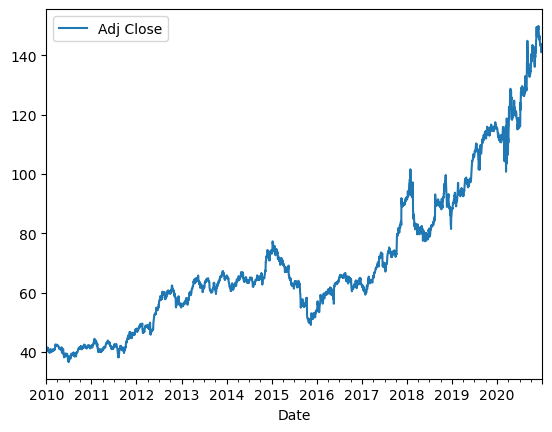

In [75]:
#plot ts  
ts.plot(label= 'Adj Close') 

In [76]:
#Check the time series for stationarity
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.467517,23,2846,0.9974,0.05,False


In [77]:
# check  n diff  need  ? 
ndiffs(ts)

1

In [78]:
ts_diff =  ts.diff().dropna()
get_adfuller_results(ts_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.193364,22,2846,0.0,0.05,True


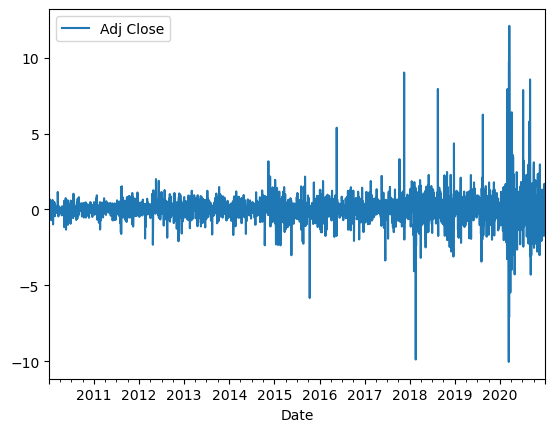

In [79]:
ax  = ts_diff.plot(label = 'WMT stationary' )



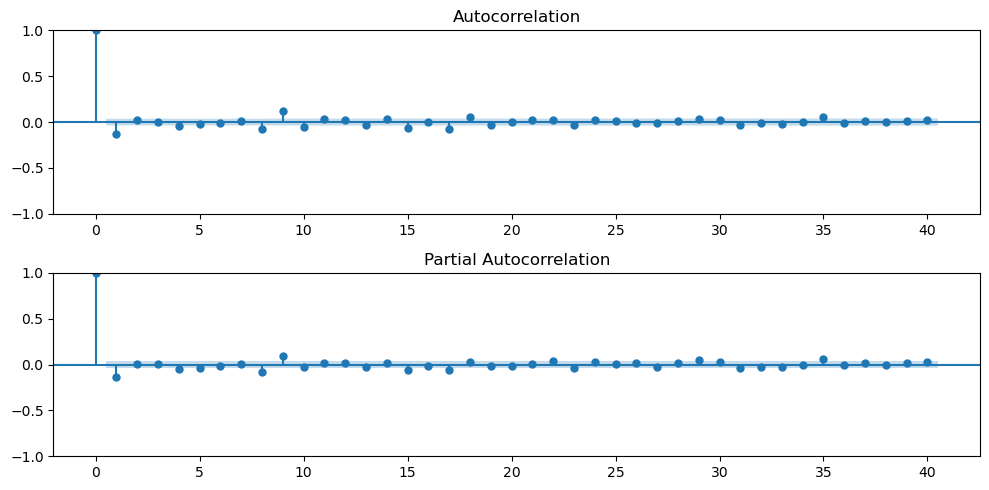

In [80]:

# Let's call our custom acf/pacf plot on our stationary (d = 1) data
fig =plot_acf_pacf(ts_diff)

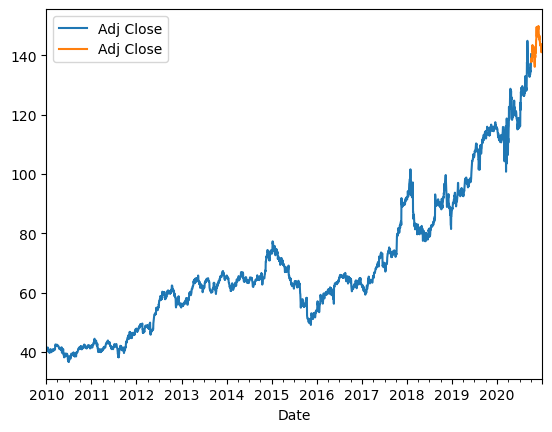

In [81]:
# try pdq =   (1, 1, 1 ) 
# Split the time series into training and test data. Use a test_size of one quarter (13 weeks X 5 business days) 
n_test_lage= 13*5
train, test =  train_test_split(ts ,test_size=n_test_lage)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();


In [82]:
# Build the model 
p = 1  # AR component 

d = 1  # Number of differencing required to make stationary

q =  1 # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()



In [83]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3883.757
Date:                Sun, 09 Jun 2024   AIC                           7773.515
Time:                        16:15:51   BIC                           7791.331
Sample:                    01-01-2010   HQIC                          7779.945
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2436      0.043     -5.647      0.000      -0.328      -0.159
ma.L1          0.1138      0.046      2.483      0.013       0.024       0.204
sigma2         0.9345      0.006    144.937      0.000       0.922       0.947
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            110531.33
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              10.44   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.765
- MSE = 22.347
- RMSE = 4.727
- R^2 = -0.750
- MAPE = 2.59%


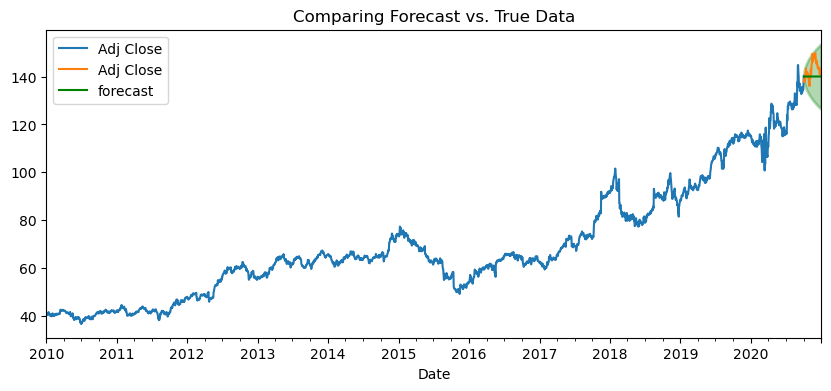

In [84]:
# Make forecasts with  model
forecast_df = arima_model.get_forecast(steps = len(test)).summary_frame()
plot_forecast(train,test,forecast_df)
regression_metrics_ts(test,forecast_df['mean'])

* Try at least one variation of the model for comparison (we recommend using a loop to try combinations of model orders)

In [85]:
## loop 
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 4)  
d_values = [1]          
q_values = range(0, 4)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try


[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

In [86]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 1, 0) 7819.208494266164
(0, 1, 1) 7774.266617768649
(0, 1, 2) 7773.899773854788
(0, 1, 3) 7774.418547804318
(1, 1, 0) 7772.191998459344
(1, 1, 1) 7773.5146526671615
(1, 1, 2) 7775.498790774666
(1, 1, 3) 7770.448019470175
(2, 1, 0) 7773.52703021483
(2, 1, 1) 7775.507116943111
(2, 1, 2) 7777.4121239042215
(2, 1, 3) 7763.315430498649
(3, 1, 0) 7775.40336024133
(3, 1, 1) 7771.835907084273


C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) 7754.796334936575


C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 3) 7757.481216298828
Best AIC: 7754.796334936575
Best pdq: (3, 1, 2)


In [87]:
# Build the model 
p = 3  # AR component 

d = 1  # Number of differencing required to make stationary

q =  2 # MA component 

# Define and fit the model
arima_model_2 = tsa.ARIMA(train, order=(p,d,q)).fit()

C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


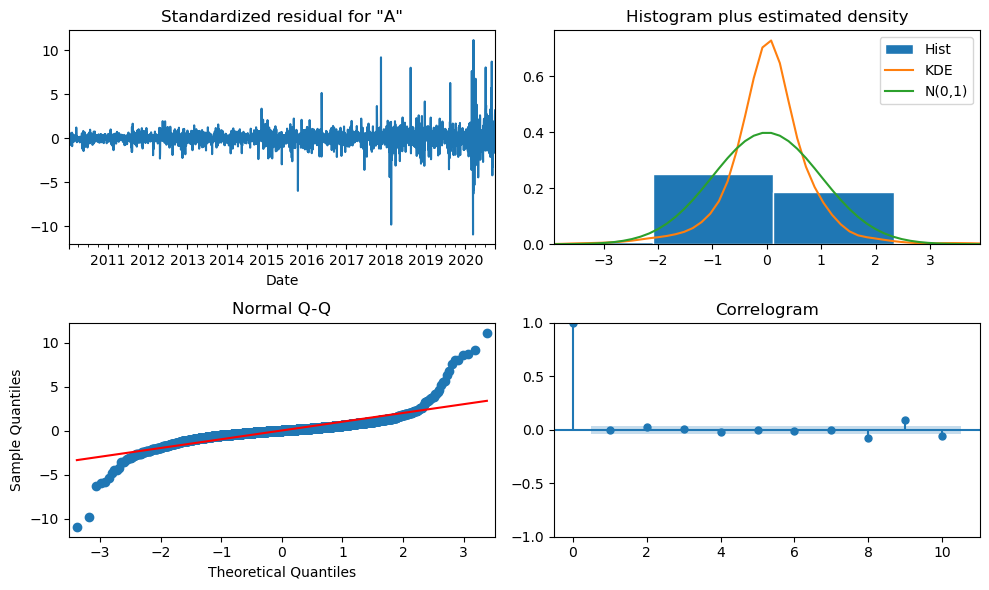

In [88]:
# Obtain diagnostic plots
fig = arima_model_2.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [89]:
arima_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2805
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -3871.398
Date:                Sun, 09 Jun 2024   AIC                           7754.796
Time:                        16:16:10   BIC                           7790.429
Sample:                    01-01-2010   HQIC                          7767.657
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6229      0.011    143.116      0.000       1.601       1.645
ar.L2         -0.7434      0.014    -54.129      0.000      -0.770      -0.716
ar.L3         -0.1265      0.007    -17.099      0.000      -0.141      -0.112
ma.L1         -1.7626      0.009   -187.680      0.000      -1.781      -1.744
ma.L2          0.9699      0.010    101.181      0.000       0.951       0.989
sigma2         0.9299      0.008    117.130      0.000       0.914       0.946
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            101150.45
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              10.18   Skew:                             0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.868
- MSE = 22.863
- RMSE = 4.781
- R^2 = -0.791
- MAPE = 2.66%


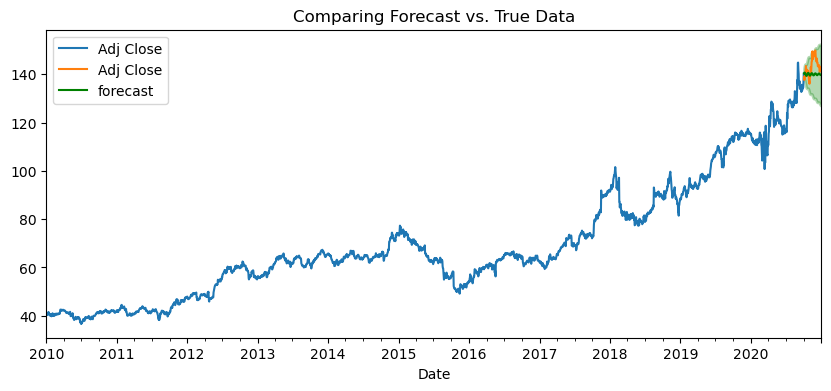

In [90]:
forecast_df2 = arima_model_2.get_forecast(steps= len(test)).summary_frame()
plot_forecast(train,test,forecast_df2)
regression_metrics_ts(test, forecast_df2['mean'])

In [91]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 4)  
d_values = [1]          
q_values = range(0, 4)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

In [92]:
best_aic = float("inf")
best_order = None
best_mape = np.inf
best_model = None
best_pdq = (0,1,0)

# Loop through each combination
for pdq in pdq_to_try:

                model = tsa.ARIMA(train, order=pdq)
                fitted_model = model.fit()
                forecast = fitted_model.forecast(steps=len(test))
                
                
                mape = mean_absolute_percentage_error(test, forecast)
                
                
                if mape < best_mape:
                    best_aic = fitted_model.aic
                    best_order = (pdq)
                    best_mape = mape
                    best_model = fitted_model
          
                


print("Best mape :", best_mape*100)
print("Best pdq:", best_pdq)
print('Best ACI : ' , best_aic)

C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters foun

Best mape : 2.015390663761645
Best pdq: (0, 1, 0)
Best ACI :  7757.481216298828


In [93]:
# Build the model 
p = 0  # AR component 

d = 1  # Number of differencing required to make stationary

q =  0 # MA component 

# Define and fit the model
arima_model_3 = tsa.ARIMA(train, order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.601
- MSE = 20.628
- RMSE = 4.542
- R^2 = -0.616
- MAPE = 2.48%


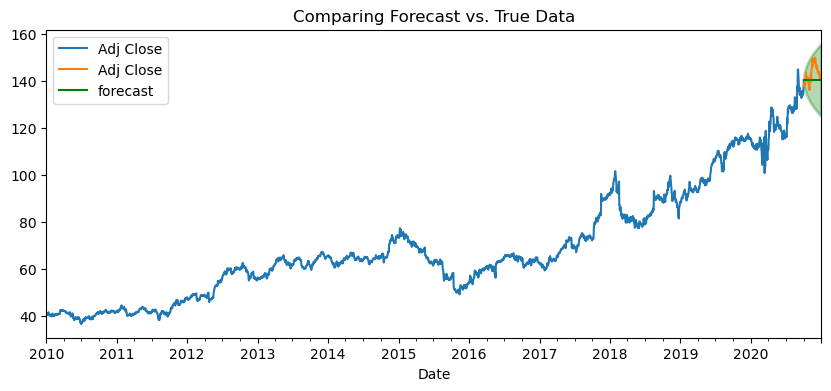

In [94]:
forecast_df3 = arima_model_3.get_forecast(steps= len(test)).summary_frame()
plot_forecast(train,test,forecast_df3)
regression_metrics_ts(test, forecast_df3['mean'])

# Conclusion:
arima model  = (1,1,1) is the better model based on the given metrics. It has lower MAE, MSE, RMSE, and MAPE values, indicating better overall accuracy and performance compared to Model 2. Therefore,arima model  = (1,1,1) is the preferred model for time series forecasting in this case.